In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
# install Python Reddit API Wrapper for getting external data Karma
%pip install pyspark==3.4.0
# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.driver.memory","16G")
    .config("spark.driver.maxResultSize", "0") 
    .config("spark.kryoserializer.buffer.max", "2000M")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e3013acf-3c41-4aed-8666-7b6dd10b8053;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [4]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")
comments=comments.sample(withReplacement=False, fraction=0.1, seed=123)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-166335636271/project/comments/yyyy=*


23/12/05 01:02:13 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,053,280x21


shape of the comments dataframe is 105,716x21
CPU times: user 4.5 s, sys: 579 ms, total: 5.08 s
Wall time: 22min 8s


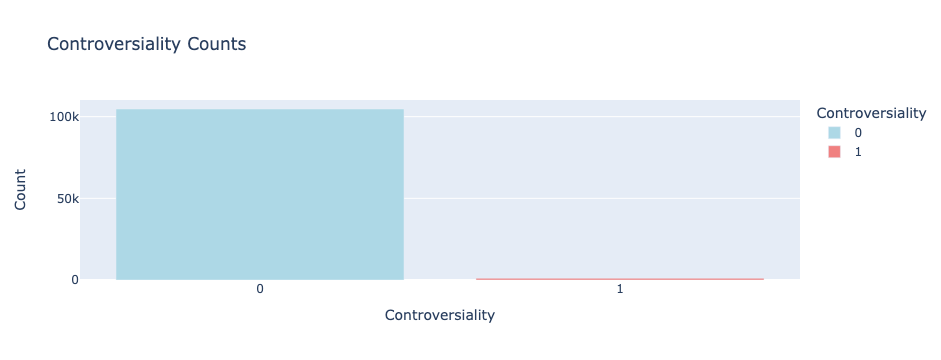

In [14]:
comments_contro = comments.select("score", "gilded", "controversiality")

comments_contro = comments_contro.withColumn("controversiality", col("controversiality").cast(StringType()))

# Convert the 'controversiality' column to a PySpark DataFrame
df = comments_contro.groupBy("controversiality").count()

# Create a bar chart using Plotly Express
fig = px.bar(df.toPandas(), x="controversiality", y="count",
             labels={"controversiality": "Controversiality", "count": "Count"},
             title="Controversiality Counts",
             color="controversiality",
             color_discrete_map={"0": "lightblue", "1": "lightcoral"})

# Save the plot as an HTML file
fig.write_html("/root/fall-2023-reddit-project-team-33/data/plots/EDA_contro.html")

# Show the plot
fig.show()


In [16]:
df.show()

+----------------+------+
|controversiality| count|
+----------------+------+
|               0|104693|
|               1|  1023|
+----------------+------+



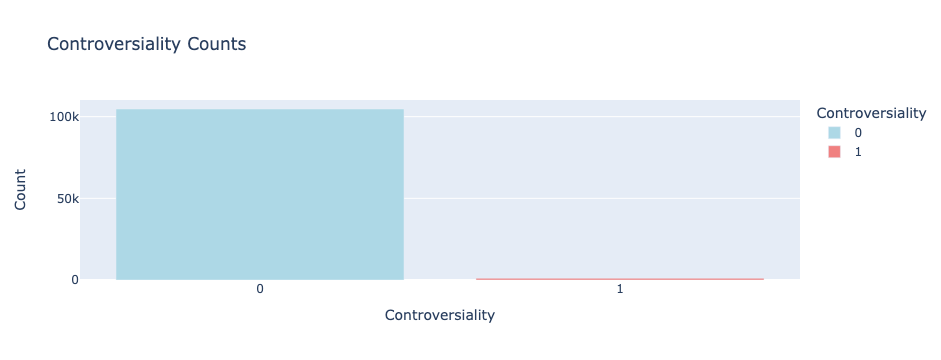

In [17]:

# Save the plot as an HTML file
fig.write_html("/root/fall-2023-reddit-project-team-33/data/plots/EDA_contro.html")

# Show the plot
fig.show()

### Data Overview:
The provided dataset consists of a total of 105,716 comments. Within this dataset, comments are categorized based on their controversiality values. Specifically, 104,693 comments have a controversiality value of 0, indicating non-controversial comments, while 1,023 comments have a controversiality value of 1, representing controversial comments.

### Controversiality Distribution:
The distribution of controversiality values reveals a significant imbalance in the dataset. Approximately 99% of comments fall into the non-controversial category (controversiality = 0), while the remaining 1% is attributed to controversial comments (controversiality = 1).

### Business Insight

The dataset reveals a notable imbalance in controversiality values, with 99% of comments considered non-controversial (controversiality = 0) and just 1% identified as controversial (controversiality = 1). This indicates a generally positive community engagement, yet there's room for improvement by exploring the characteristics of the limited controversial comments. Prioritizing content moderation for this small percentage is crucial to sustain a respectful online environment. Encouraging user feedback, particularly on controversial comments, is pivotal for addressing user concerns. Looking ahead, a more detailed analysis of controversial comments is essential, and exploring machine learning methods to discern patterns in controversiality data could provide a deeper understanding of user sentiments and behaviors.
